In [1]:
import trimesh
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear

from torch.utils.data import TensorDataset, DataLoader
from torch import optim

# Load Pyramid mesh

In [2]:
mesh_pyramid = trimesh.load('data/cube2.obj')
mesh_pyramid.show(viewer='notebook', smooth=False)

In [3]:
mesh_pyramid.is_watertight

True

In [4]:
mesh_pyramid_bb = mesh_pyramid.bounding_box
mesh_pyramid_bb_arr = np.array(mesh_pyramid_bb.vertices)


# Pyramid mesh processing

Point generation for dataset

In [5]:
min_x, max_x = np.amin(mesh_pyramid_bb_arr.T[0]), np.amax(mesh_pyramid_bb_arr.T[0])
min_y, max_y = np.amin(mesh_pyramid_bb_arr.T[1]), np.amax(mesh_pyramid_bb_arr.T[1])
min_z, max_z = np.amin(mesh_pyramid_bb_arr.T[2]), np.amax(mesh_pyramid_bb_arr.T[2])

In [6]:
delta = 5
points_train = np.float_([
    [x_, y_, z_] for z_ in np.linspace(min_z-delta, max_z+delta, 20) 
    for y_ in np.linspace(min_y-delta, max_y+delta, 20) 
    for x_ in np.linspace(min_x-delta, max_x+delta, 20)
])
points_train.shape

(8000, 3)

In [7]:
sdf_data = np.array([-1*p for p in mesh_pyramid.nearest.signed_distance(points_train)])

# Create and train models

Add visualization

In [8]:
losses = {}

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8, 6)})


def loss_graph(losses, net_list):  
    for experiment_id in net_list:
        plt.plot(losses[experiment_id], label=experiment_id)
    
    plt.legend()
    plt.title('Validation Loss');
    plt.tight_layout()

In [9]:
def train(net, train_dl, epoch_num=200, epoch_info_show=20, 
          weight_decay=0, save_net_state=False, verbose=True):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)


    loss = torch.nn.L1Loss().to(device)   
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)

    t = time.time()
    loss_history = []
    
    for epoch in range(1, epoch_num+1):
        
        
        total_loss = 0
        for points_b, sdfs_b in train_dl:
            
            points_b = points_b.to(device)
            sdfs_b = sdfs_b.to(device)
            
            pred = net.forward(points_b)
            pred = pred.squeeze()
            loss_value = loss(pred, sdfs_b)
            total_loss += loss_value
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        loss_history.append(total_loss.item())
        if epoch % epoch_info_show == 0:
            time_ = time.strftime("%H:%M:%S", time.gmtime(time.time() - t))
            print(f'Train Epoch: {epoch} Time: {time_} Loss: {round(total_loss.item(), 4)}')   

    net_state = net.state_dict()
    del net
    return loss_history

torch.cuda.empty_cache()

In [10]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_data))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

## FC model 7-layer

In [11]:
class Net7(nn.Module):

    def __init__(self):
        super(Net7, self).__init__()
        self.fc1 = nn.Linear(3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 200)
        self.fc7 = nn.Linear(200, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net7 = Net7()
net7

Net7(
  (fc1): Linear(in_features=3, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (fc7): Linear(in_features=200, out_features=1, bias=True)
)

In [12]:
losses['FcNet7']  = train(net7, train_dl, 500, 100, False, True)

Train Epoch: 100 Time: 00:00:07 Loss: 1.1694
Train Epoch: 200 Time: 00:00:15 Loss: 0.3652
Train Epoch: 300 Time: 00:00:23 Loss: 0.3775
Train Epoch: 400 Time: 00:00:30 Loss: 0.3026
Train Epoch: 500 Time: 00:00:38 Loss: 0.2451


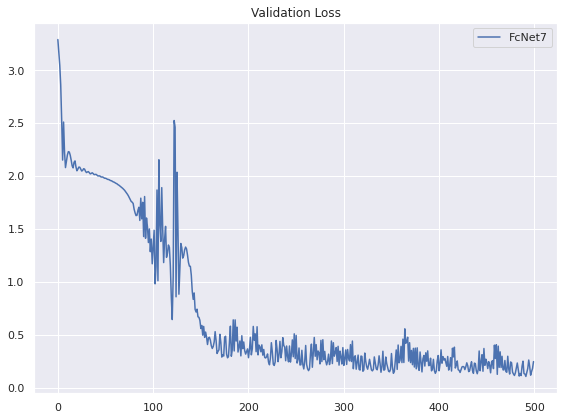

In [13]:
loss_graph(losses, ['FcNet7'])

In [14]:
class Net12(nn.Module):

    def __init__(self):
        super(Net12, self).__init__()
        self.fc1 = nn.Linear(3, 200)
        
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 200)
        
        self.fc7 = nn.Linear(200, 200)
        self.fc8 = nn.Linear(200, 200)
        self.fc9 = nn.Linear(200, 200)
        self.fc10 = nn.Linear(200, 200)
        self.fc11 = nn.Linear(200, 200)
        
        self.fc12 = nn.Linear(200, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        
        x = self.fc12(x)
        return x

net12 = Net12()
print(net12)

Net12(
  (fc1): Linear(in_features=3, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (fc7): Linear(in_features=200, out_features=200, bias=True)
  (fc8): Linear(in_features=200, out_features=200, bias=True)
  (fc9): Linear(in_features=200, out_features=200, bias=True)
  (fc10): Linear(in_features=200, out_features=200, bias=True)
  (fc11): Linear(in_features=200, out_features=200, bias=True)
  (fc12): Linear(in_features=200, out_features=1, bias=True)
)


In [15]:
losses['FcNet12']  = train(net12, train_dl, 500, 100, False, True)

Train Epoch: 100 Time: 00:00:08 Loss: 1.6216
Train Epoch: 200 Time: 00:00:16 Loss: 0.778
Train Epoch: 300 Time: 00:00:25 Loss: 0.3076
Train Epoch: 400 Time: 00:00:33 Loss: 0.6112
Train Epoch: 500 Time: 00:00:41 Loss: 0.3126


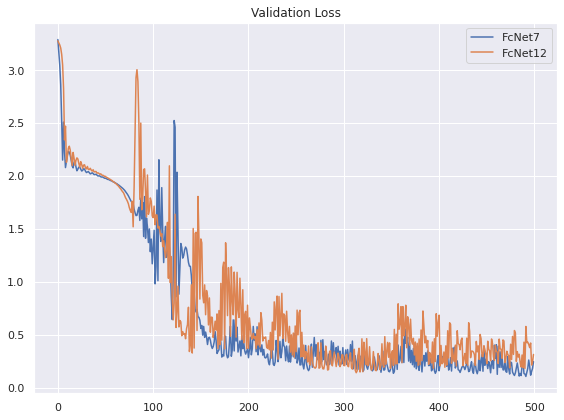

In [16]:
loss_graph(losses, ['FcNet7', 'FcNet12'])

## Apply ConvNet

In [17]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()        
        self.input_layer = Conv1d(3, 10, 1)
        self.max_pooling_layer = MaxPool1d(1)
        self.conv_layer = Conv1d(10, 50, 1)
        self.flatten_layer = Flatten()
        self.linear_layer = Linear(50, 50)
        self.output_layer = Linear(50, 1)

    def forward(self, x):
        if len(x.size()) == 1:
            n = 1
            
        else:
            n = x.size()[0]
        
        x = x.reshape((n, 3, 1))

        x = F.relu(self.input_layer(x))
        x = self.max_pooling_layer(x)
        x = F.relu(self.conv_layer(x))
        x = self.flatten_layer(x)
        x = self.linear_layer(x)
        x = self.output_layer(x)
        return x
    
    
cnn = ConvNet()
cnn

ConvNet(
  (input_layer): Conv1d(3, 10, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(10, 50, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=50, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=1, bias=True)
)

In [18]:
losses['ConvNet']  = train(cnn, train_dl, 500, 100, False, True)

Train Epoch: 100 Time: 00:00:07 Loss: 1.8872
Train Epoch: 200 Time: 00:00:15 Loss: 0.6649
Train Epoch: 300 Time: 00:00:22 Loss: 0.3446
Train Epoch: 400 Time: 00:00:30 Loss: 0.2585
Train Epoch: 500 Time: 00:00:38 Loss: 0.24


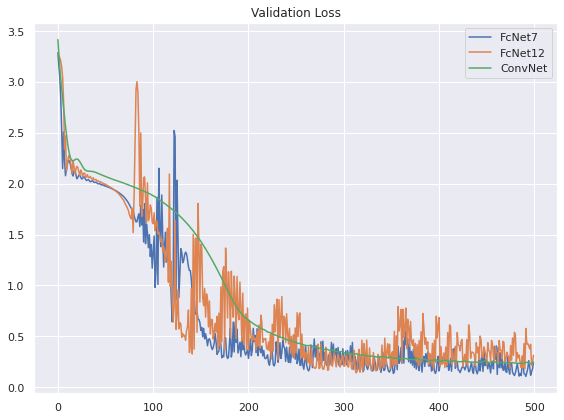

In [19]:
loss_graph(losses, ['FcNet7', 'FcNet12', 'ConvNet'])

# Inference

In [21]:
pytorch_total_params = sum(p.numel() for p in net7.parameters())
pytorch_total_params

202001

In [22]:
pytorch_total_params = sum(p.numel() for p in net12.parameters())
pytorch_total_params

403001

In [23]:
pytorch_total_params = sum(p.numel() for p in cnn.parameters())
pytorch_total_params

3191

serialize model

In [24]:
torch.save(net7, f"models/net7.pt")
torch.save(net12, f"models/net12.pt")
torch.save(cnn, f"models/cnn.pt")

/home/sashatr/Desktop/sdf_test_task/venv/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net7. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sashatr/Desktop/sdf_test_task/venv/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net12. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sashatr/Desktop/sdf_test_task/venv/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
idx = 4000
xyz, sdf = points_train[idx], sdf_data[idx]
xyz, sdf

(array([-15.        , -15.        ,   0.78947368]), 7.0710678118654755)

In [26]:
net7.cpu()
net12.cpu()
cnn.cpu()

output_net7 = net7(torch.Tensor(xyz)).item()
output_net12 = net12(torch.Tensor(xyz)).item()
output_cnn = cnn(torch.Tensor(xyz)).item()

output_net7, output_net12 , output_cnn

(7.344844341278076, 5.991343975067139, 6.926909923553467)

# TODO:
 - ~~fix shapes for Net model~~
 - improve loss func
 - ~~prepare dats for ConvNet and train ConvNet~~